In [1]:
import sys

# setting path
sys.path.append('..')

In [2]:
# local package
import classified

In [3]:
# outside package
import requests
import pandas as pd
import time
import json
from multiprocessing.dummy import Pool
import numpy as np

# Matches Data

## Fetch Matches Data

In [4]:
def use_api(address, params=None, method="get"):
    if params is None:
        params = {"api_key": classified.API_KEY}
    else:
        params["api_key"] = classified.API_KEY
    method = getattr(requests, method)
    return method(address, params=params).json()

In [11]:
pro_matches = []

In [14]:
for i in range(0, 10000, 1000):
    result = use_api(
        "https://api.opendota.com/api/explorer",
        params={"sql":
                    """
                        SELECT
                            matches.match_id
                        FROM
                            matches
                            JOIN match_patch USING ( match_id )
                            JOIN leagues USING ( leagueid )
                            JOIN player_matches USING ( match_id )
                            JOIN heroes ON heroes.id = player_matches.hero_id
                            LEFT JOIN notable_players ON notable_players.account_id = player_matches.account_id
                            LEFT JOIN teams USING ( team_id )
                        WHERE
                        TRUE
                            AND match_patch.patch >= '7.28'
                            AND leagues.tier = 'professional'
                        GROUP BY
                            matches.match_id
                        ORDER BY
                            matches.match_id NULLS LAST
                            LIMIT 1000 OFFSET {}
                    """.format(i)}
    )
    pro_matches += result["rows"]
    print("First {} data fetched.".format(i + 1000))
    time.sleep(1)

First 1000 data fetched.
First 2000 data fetched.
First 3000 data fetched.
First 4000 data fetched.
First 5000 data fetched.
First 6000 data fetched.
First 7000 data fetched.
First 8000 data fetched.
First 9000 data fetched.
First 10000 data fetched.


In [15]:
pro_matches = [i["match_id"] for i in pro_matches]

In [25]:
data = []

In [26]:
def get_match_data(match_id):
    kept_keys = ["match_id", "radiant_win", "region", "patch", "picks_bans"]
    try:
        result = use_api("https://api.opendota.com/api/matches/{match_id}".format(match_id=match_id))
        data.append({k: result[k] for k in kept_keys})
        time.sleep(1)
    except Exception:
        pass

In [27]:
pool = Pool(5)
pool.map(get_match_data, pro_matches)
len(data)

9383

In [6]:
pd.DataFrame(data).head()

,match_id,radiant_win,region,patch,picks_bans
0,5746455668,False,3,47,"[{'is_pick': False, 'hero_id': 85, 'team': 1, ..."
1,5795993534,True,3,47,"[{'is_pick': False, 'hero_id': 65, 'team': 0, ..."
2,5883814830,True,5,47,"[{'is_pick': False, 'hero_id': 102, 'team': 1,..."
3,5860105982,True,17,47,"[{'is_pick': False, 'hero_id': 38, 'team': 0, ..."
4,5831784791,True,3,47,"[{'is_pick': False, 'hero_id': 7, 'team': 1, '..."


In [29]:
with open("../data/raw_data/data.json", "w") as f:
    json.dump({"data": data}, f)

## Process Pro Matches Data

In [5]:
with open("../data/raw_data/data.json", "r") as f:
    data = json.load(f)["data"]

In [255]:
data[0]["picks_bans"][0]

{'is_pick': False,
 'hero_id': 85,
 'team': 1,
 'order': 0,
 'ord': 0,
 'match_id': 5746455668}

In [256]:
data = pd.DataFrame(data).dropna()
data.head()

,match_id,radiant_win,region,patch,picks_bans
0,5746455668,False,3,47,"[{'is_pick': False, 'hero_id': 85, 'team': 1, ..."
1,5795993534,True,3,47,"[{'is_pick': False, 'hero_id': 65, 'team': 0, ..."
2,5883814830,True,5,47,"[{'is_pick': False, 'hero_id': 102, 'team': 1,..."
3,5860105982,True,17,47,"[{'is_pick': False, 'hero_id': 38, 'team': 0, ..."
4,5831784791,True,3,47,"[{'is_pick': False, 'hero_id': 7, 'team': 1, '..."


In [257]:
data["first_pick_team"] = data.picks_bans.apply(lambda x: x[0]["team"])
data.head()

,match_id,radiant_win,region,patch,picks_bans,first_pick_team
0,5746455668,False,3,47,"[{'is_pick': False, 'hero_id': 85, 'team': 1, ...",1
1,5795993534,True,3,47,"[{'is_pick': False, 'hero_id': 65, 'team': 0, ...",0
2,5883814830,True,5,47,"[{'is_pick': False, 'hero_id': 102, 'team': 1,...",1
3,5860105982,True,17,47,"[{'is_pick': False, 'hero_id': 38, 'team': 0, ...",0
4,5831784791,True,3,47,"[{'is_pick': False, 'hero_id': 7, 'team': 1, '...",1


In [258]:
data.picks_bans = data.picks_bans.apply(lambda x: [i["hero_id"] for i in x])
data = data[data.picks_bans.apply(lambda x: len(x)) == 24]
data.head()

,match_id,radiant_win,region,patch,picks_bans,first_pick_team
0,5746455668,False,3,47,"[85, 91, 79, 41, 43, 107, 51, 10, 53, 68, 22, ...",1
1,5795993534,True,3,47,"[65, 88, 32, 111, 13, 30, 78, 86, 70, 95, 93, ...",0
2,5883814830,True,5,47,"[102, 88, 73, 13, 86, 103, 29, 91, 93, 68, 10,...",1
3,5860105982,True,17,47,"[38, 88, 9, 13, 111, 26, 107, 129, 77, 10, 43,...",0
4,5831784791,True,3,47,"[7, 90, 88, 91, 111, 13, 65, 102, 38, 27, 33, ...",1


In [259]:
picks_bans = data.picks_bans.apply(pd.Series)
picks_bans.columns = ["selection_{}".format(i) for i in range(24)]
picks_bans.head()

,selection_0,selection_1,selection_2,selection_3,selection_4,selection_5,selection_6,selection_7,selection_8,selection_9,...,selection_14,selection_15,selection_16,selection_17,selection_18,selection_19,selection_20,selection_21,selection_22,selection_23
0,85,91,79,41,43,107,51,10,53,68,...,47,20,64,94,128,65,4,33,28,55
1,65,88,32,111,13,30,78,86,70,95,...,38,51,12,4,47,54,46,11,55,114
2,102,88,73,13,86,103,29,91,93,68,...,129,121,110,32,113,106,126,17,39,74
3,38,88,9,13,111,26,107,129,77,10,...,102,42,126,11,70,29,12,60,104,18
4,7,90,88,91,111,13,65,102,38,27,...,86,107,94,1,28,49,2,22,55,104


In [260]:
data = data.drop("picks_bans", axis=1)
data = pd.concat([data, picks_bans], axis=1)

,match_id,radiant_win,region,patch,first_pick_team,selection_0,selection_1,selection_2,selection_3,selection_4,...,selection_14,selection_15,selection_16,selection_17,selection_18,selection_19,selection_20,selection_21,selection_22,selection_23
0,5746455668,False,3,47,1,85,91,79,41,43,...,47,20,64,94,128,65,4,33,28,55
1,5795993534,True,3,47,0,65,88,32,111,13,...,38,51,12,4,47,54,46,11,55,114
2,5883814830,True,5,47,1,102,88,73,13,86,...,129,121,110,32,113,106,126,17,39,74
3,5860105982,True,17,47,0,38,88,9,13,111,...,102,42,126,11,70,29,12,60,104,18
4,5831784791,True,3,47,1,7,90,88,91,111,...,86,107,94,1,28,49,2,22,55,104


In [268]:
data.to_csv("../data/processed_data/data.json")

In [5]:
data = pd.read_csv("../data/processed_data/data.json", index_col=0)
data.head()

,match_id,radiant_win,region,patch,first_pick_team,selection_0,selection_1,selection_2,selection_3,selection_4,...,selection_14,selection_15,selection_16,selection_17,selection_18,selection_19,selection_20,selection_21,selection_22,selection_23
0,5746455668,False,3,47,1,85,91,79,41,43,...,47,20,64,94,128,65,4,33,28,55
1,5795993534,True,3,47,0,65,88,32,111,13,...,38,51,12,4,47,54,46,11,55,114
2,5883814830,True,5,47,1,102,88,73,13,86,...,129,121,110,32,113,106,126,17,39,74
3,5860105982,True,17,47,0,38,88,9,13,111,...,102,42,126,11,70,29,12,60,104,18
4,5831784791,True,3,47,1,7,90,88,91,111,...,86,107,94,1,28,49,2,22,55,104


# Heroes Data

## Fetch Heroes Data

In [271]:
heroes_data = pd.DataFrame(use_api("https://api.opendota.com/api/heroes"))
heroes_data = heroes_data[["id", "localized_name"]]
heroes_data.columns = ["id", "name"]
heroes_data.head()

,id,name
0,1,Anti-Mage
1,2,Axe
2,3,Bane
3,4,Bloodseeker
4,5,Crystal Maiden


## Fetch Matchup Data

In [126]:
matchup_data = heroes_data["id"].apply(lambda x: use_api("https://api.opendota.com/api/heroes/{}/matchups".format(x)))
matchup_data.head()

0    [{'hero_id': 16, 'games_played': 188, 'wins': ...
1    [{'hero_id': 86, 'games_played': 145, 'wins': ...
2    [{'hero_id': 129, 'games_played': 512, 'wins':...
3    [{'hero_id': 120, 'games_played': 419, 'wins':...
4    [{'hero_id': 86, 'games_played': 493, 'wins': ...
Name: id, dtype: object

## Combine and Process Data

In [272]:
columns_to_add = [{"win_rate": np.nan}]
for i in heroes_data["id"].to_list():
    columns_to_add.append({"against_hero_{}".format(int(i)): np.nan})
heroes_data = pd.concat([heroes_data, pd.DataFrame(columns_to_add)], axis=1)
heroes_data.drop(123, axis=0, inplace=True)
heroes_data["id"] = heroes_data["id"].astype(int)
heroes_data.head()

,id,name,win_rate,against_hero_1,against_hero_2,against_hero_3,against_hero_4,against_hero_5,against_hero_6,against_hero_7,...,against_hero_119,against_hero_120,against_hero_121,against_hero_123,against_hero_126,against_hero_128,against_hero_129,against_hero_135,against_hero_136,against_hero_137
0,1,Anti-Mage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,Axe,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,Bane,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,Bloodseeker,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,Crystal Maiden,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [273]:
def add_to_heroes_data(row):
    heroes_data.loc[i, "against_hero_{}".format(int(row.hero_id))] = row.win_rate


for i in range(123):
    df = pd.DataFrame(matchup_data.iloc[i])
    df["win_rate"] = df["wins"] / df["games_played"]
    heroes_data.loc[i, "win_rate"] = df["wins"].sum() / df["games_played"].sum()
    df[["hero_id", "win_rate"]].apply(add_to_heroes_data, axis=1)

In [274]:
heroes_data.head()

,id,name,win_rate,against_hero_1,against_hero_2,against_hero_3,against_hero_4,against_hero_5,against_hero_6,against_hero_7,...,against_hero_119,against_hero_120,against_hero_121,against_hero_123,against_hero_126,against_hero_128,against_hero_129,against_hero_135,against_hero_136,against_hero_137
0,1,Anti-Mage,0.489100,NaN,0.566667,0.464789,0.447368,0.441860,0.608696,0.588235,...,0.545455,0.500000,0.535433,0.381579,0.477273,0.460526,0.413793,0.428571,0.520000,0.521739
1,2,Axe,0.485514,0.433333,NaN,0.474576,0.576923,0.471264,0.507937,0.666667,...,0.473684,0.482143,0.474227,0.508475,0.486486,0.490196,0.544828,0.419355,0.471429,0.392857
2,3,Bane,0.552398,0.535211,0.525424,NaN,0.605042,0.576087,0.495413,0.562500,...,0.516129,0.530928,0.592018,0.617925,0.616822,0.595745,0.583984,0.547945,0.490066,0.589744
3,4,Bloodseeker,0.496582,0.552632,0.423077,0.394958,NaN,0.589147,0.480769,0.490909,...,0.480000,0.515513,0.620321,0.537313,0.567164,0.506550,0.517647,0.517413,0.483871,0.387755
4,5,Crystal Maiden,0.496833,0.558140,0.528736,0.423913,0.410853,NaN,0.491124,0.461538,...,0.519481,0.507519,0.550296,0.516807,0.400000,0.482085,0.538462,0.492593,0.490141,0.514851


In [275]:
heroes_data.to_csv("../data/processed_data/heroes_data.csv")

In [6]:
heroes_data = pd.read_csv("../data/processed_data/heroes_data.csv", index_col=0)
heroes_data.head()

,id,name,win_rate,against_hero_1,against_hero_2,against_hero_3,against_hero_4,against_hero_5,against_hero_6,against_hero_7,...,against_hero_119,against_hero_120,against_hero_121,against_hero_123,against_hero_126,against_hero_128,against_hero_129,against_hero_135,against_hero_136,against_hero_137
0,1,Anti-Mage,0.489100,NaN,0.566667,0.464789,0.447368,0.441860,0.608696,0.588235,...,0.545455,0.500000,0.535433,0.381579,0.477273,0.460526,0.413793,0.428571,0.520000,0.521739
1,2,Axe,0.485514,0.433333,NaN,0.474576,0.576923,0.471264,0.507937,0.666667,...,0.473684,0.482143,0.474227,0.508475,0.486486,0.490196,0.544828,0.419355,0.471429,0.392857
2,3,Bane,0.552398,0.535211,0.525424,NaN,0.605042,0.576087,0.495413,0.562500,...,0.516129,0.530928,0.592018,0.617925,0.616822,0.595745,0.583984,0.547945,0.490066,0.589744
3,4,Bloodseeker,0.496582,0.552632,0.423077,0.394958,NaN,0.589147,0.480769,0.490909,...,0.480000,0.515513,0.620321,0.537313,0.567164,0.506550,0.517647,0.517413,0.483871,0.387755
4,5,Crystal Maiden,0.496833,0.558140,0.528736,0.423913,0.410853,NaN,0.491124,0.461538,...,0.519481,0.507519,0.550296,0.516807,0.400000,0.482085,0.538462,0.492593,0.490141,0.514851


In [285]:
heroes_data[["name", "win_rate"]].describe()

,win_rate
count,123.000000
mean,0.498494
std,0.028327
min,0.431899
25%,0.483330
50%,0.496572
75%,0.514233
max,0.581066


<AxesSubplot: ylabel='name'>

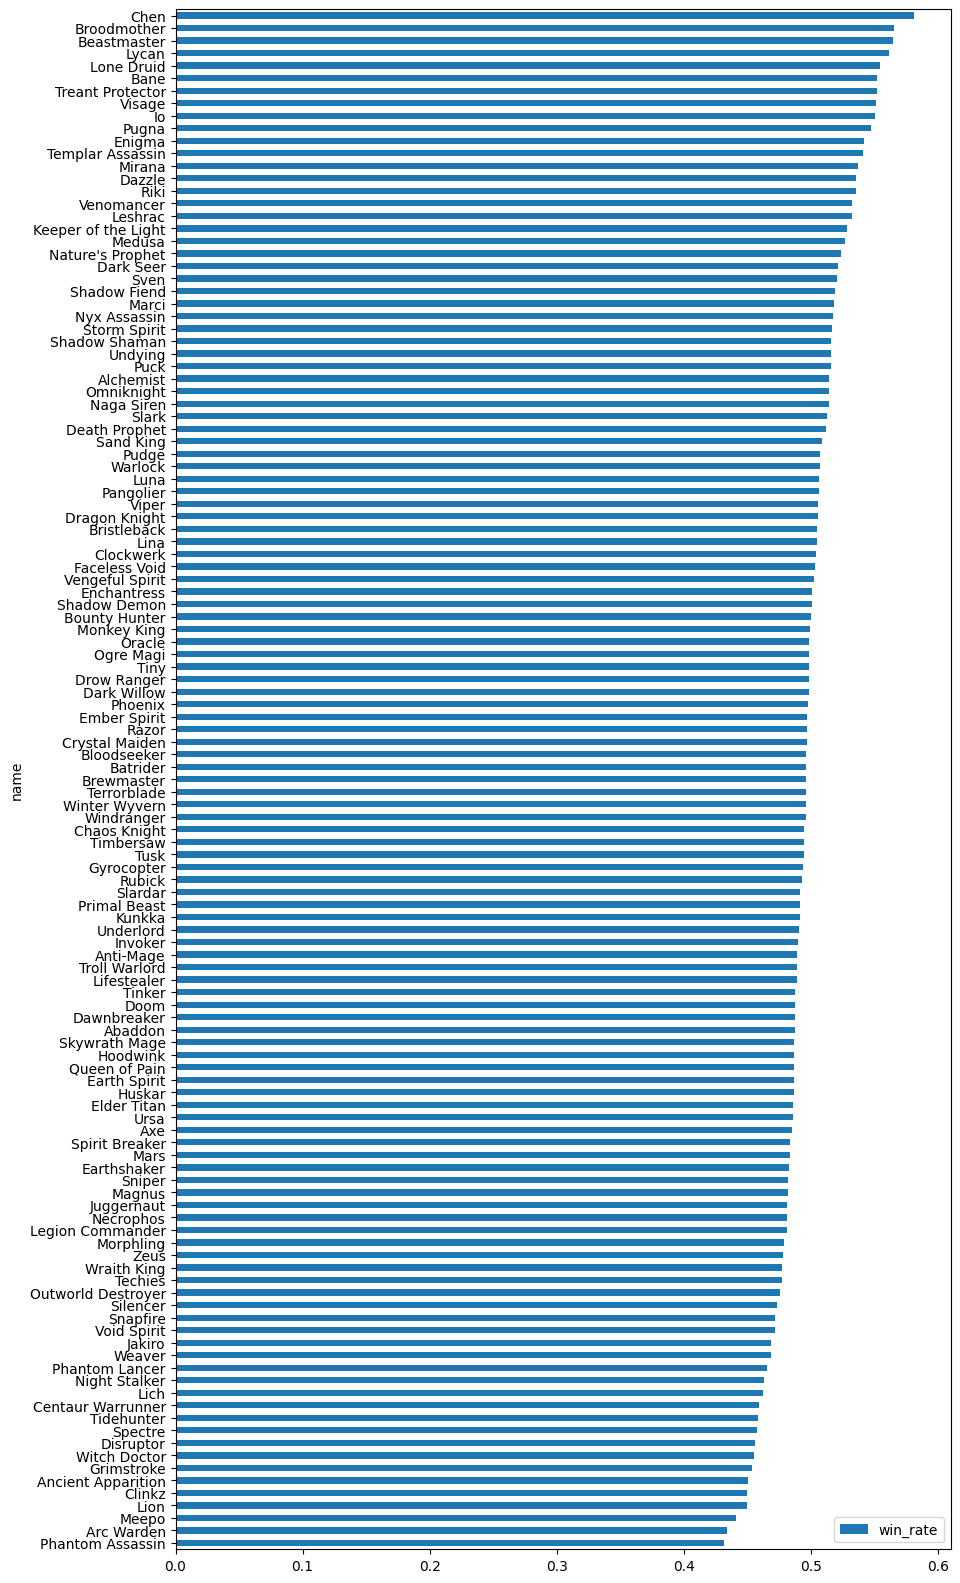

In [306]:
heroes_data[["name", "win_rate"]].sort_values("win_rate").plot.barh(x="name", y="win_rate", figsize=(10,20))

# Hero Stats

In [23]:
hero_stats = pd.DataFrame(use_api("https://api.opendota.com/api/heroStats"))
hero_stats.head()

,id,name,localized_name,primary_attr,attack_type,roles,img,icon,base_health,base_health_regen,...,5_pick,5_win,6_pick,6_win,7_pick,7_win,8_pick,8_win,null_pick,null_win
0,1,npc_dota_hero_antimage,Anti-Mage,agi,Melee,"[Carry, Escape, Nuker]",/apps/dota2/images/dota_react/heroes/antimage....,/apps/dota2/images/dota_react/heroes/icons/ant...,200,0.25,...,18103,9290,8028,4112,3785,1936,1288,636,1868679,0
1,2,npc_dota_hero_axe,Axe,str,Melee,"[Initiator, Durable, Disabler, Jungler, Carry]",/apps/dota2/images/dota_react/heroes/axe.png?,/apps/dota2/images/dota_react/heroes/icons/axe...,200,2.50,...,19227,9555,7946,3888,3420,1648,951,438,2358827,0
2,3,npc_dota_hero_bane,Bane,int,Ranged,"[Support, Disabler, Nuker, Durable]",/apps/dota2/images/dota_react/heroes/bane.png?,/apps/dota2/images/dota_react/heroes/icons/ban...,200,0.25,...,2855,1381,1468,727,764,387,356,171,472537,0
3,4,npc_dota_hero_bloodseeker,Bloodseeker,agi,Melee,"[Carry, Disabler, Jungler, Nuker, Initiator]",/apps/dota2/images/dota_react/heroes/bloodseek...,/apps/dota2/images/dota_react/heroes/icons/blo...,200,0.25,...,5796,2802,2620,1237,1365,688,767,371,960797,0
4,5,npc_dota_hero_crystal_maiden,Crystal Maiden,int,Ranged,"[Support, Disabler, Nuker, Jungler]",/apps/dota2/images/dota_react/heroes/crystal_m...,/apps/dota2/images/dota_react/heroes/icons/cry...,200,0.25,...,25603,12772,12001,6078,6089,3059,2981,1461,2702209,0


In [24]:
overall_pick = hero_stats["pro_pick"].copy()
overall_win = hero_stats["pro_win"].copy()
for i in range(1, 9):
    overall_pick += hero_stats[f"{i}_pick"]
    overall_win += hero_stats[f"{i}_win"]

overall_win_rate = overall_win / overall_pick
overall_win_rate.head()

0    0.518313
1    0.522494
2    0.473363
3    0.491675
4    0.508658
dtype: float64

In [25]:
hero_roles = hero_stats["roles"].explode()
hero_roles = pd.crosstab(hero_roles.index, hero_roles)
hero_roles.head()

roles,Carry,Disabler,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support
row_0,,,,,,,,,
0,1,0,0,1,0,0,1,0,0
1,1,1,1,0,1,1,0,0,0
2,0,1,1,0,0,0,1,0,1
3,1,1,0,0,1,1,1,0,0
4,0,1,0,0,0,1,1,0,1


In [26]:
hero_attr = pd.get_dummies(hero_stats["primary_attr"]).iloc[:, :2]
hero_attack_type = pd.get_dummies(hero_stats["attack_type"]).iloc[:, :1]

In [27]:
hero_stats["turn_rate"] = hero_stats["turn_rate"].fillna(0.6)

In [28]:
hero_stats = hero_stats.iloc[:, :-24].drop(["name", "img", "icon", "roles", "cm_enabled", "primary_attr", "attack_type"], axis=1)
hero_stats["overall_win_rate"] = overall_win_rate

In [29]:
hero_stats = hero_stats.join([hero_roles, hero_attr, hero_attack_type])
hero_stats.head()

,id,localized_name,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_mr,base_attack_min,base_attack_max,...,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support,agi,int,Melee
0,1,Anti-Mage,200,0.25,75,0.0,0.0,25,29,33,...,0,1,0,0,1,0,0,1,0,1
1,2,Axe,200,2.50,75,0.0,-1.0,25,27,31,...,1,0,1,1,0,0,0,0,0,1
2,3,Bane,200,0.25,75,0.0,1.0,25,33,39,...,1,0,0,0,1,0,1,0,1,0
3,4,Bloodseeker,200,0.25,75,0.0,2.0,25,35,41,...,0,0,1,1,1,0,0,1,0,1
4,5,Crystal Maiden,200,0.25,75,1.0,-1.0,25,28,34,...,0,0,0,1,1,0,1,0,1,0


In [30]:
hero_stats.to_csv("../data/processed_data/heroes_stats.csv")

In [31]:
hero_stats = pd.read_csv("../data/processed_data/heroes_stats.csv", index_col=0)
hero_stats.head()

,id,localized_name,base_health,base_health_regen,base_mana,base_mana_regen,base_armor,base_mr,base_attack_min,base_attack_max,...,Durable,Escape,Initiator,Jungler,Nuker,Pusher,Support,agi,int,Melee
0,1,Anti-Mage,200,0.25,75,0.0,0.0,25,29,33,...,0,1,0,0,1,0,0,1,0,1
1,2,Axe,200,2.50,75,0.0,-1.0,25,27,31,...,1,0,1,1,0,0,0,0,0,1
2,3,Bane,200,0.25,75,0.0,1.0,25,33,39,...,1,0,0,0,1,0,1,0,1,0
3,4,Bloodseeker,200,0.25,75,0.0,2.0,25,35,41,...,0,0,1,1,1,0,0,1,0,1
4,5,Crystal Maiden,200,0.25,75,1.0,-1.0,25,28,34,...,0,0,0,1,1,0,1,0,1,0


# Merge Data


In [33]:
merged_data = data
for i in range(24):
    merged_data = merged_data.merge(
        hero_stats.drop("localized_name", axis=1).add_prefix("selection_{}_".format(i)),
        left_on="selection_{}".format(i),
        right_on="selection_{}_id".format(i),
    ).drop("selection_{}".format(i), axis=1)

In [34]:
merged_data.to_csv("../data/processed_data/merged_data.csv")

In [35]:
merged_data = pd.read_csv("../data/processed_data/merged_data.csv", index_col=0)
merged_data.head()

,match_id,radiant_win,region,patch,first_pick_team,selection_0_id,selection_0_base_health,selection_0_base_health_regen,selection_0_base_mana,selection_0_base_mana_regen,...,selection_23_Durable,selection_23_Escape,selection_23_Initiator,selection_23_Jungler,selection_23_Nuker,selection_23_Pusher,selection_23_Support,selection_23_agi,selection_23_int,selection_23_Melee
0,5746455668,False,3,47,1,85,200,0.25,75,0.25,...,0,1,1,1,0,0,0,0,1,1
1,6111186894,False,3,48,0,110,200,2.00,75,0.00,...,0,1,1,1,0,0,0,0,1,1
2,6054787486,False,5,48,0,46,200,0.25,75,0.00,...,0,1,1,1,0,0,0,0,1,1
3,5848322719,True,3,47,0,88,200,2.00,75,0.00,...,0,1,1,1,0,0,0,0,1,1
4,5807290727,True,3,47,0,129,200,0.25,75,0.50,...,0,1,1,1,0,0,0,0,1,1


In [36]:
merged_data


,match_id,radiant_win,region,patch,first_pick_team,selection_0_id,selection_0_base_health,selection_0_base_health_regen,selection_0_base_mana,selection_0_base_mana_regen,...,selection_23_Durable,selection_23_Escape,selection_23_Initiator,selection_23_Jungler,selection_23_Nuker,selection_23_Pusher,selection_23_Support,selection_23_agi,selection_23_int,selection_23_Melee
0,5746455668,False,3,47,1,85,200,0.25,75,0.25,...,0,1,1,1,0,0,0,0,1,1
1,6111186894,False,3,48,0,110,200,2.00,75,0.00,...,0,1,1,1,0,0,0,0,1,1
2,6054787486,False,5,48,0,46,200,0.25,75,0.00,...,0,1,1,1,0,0,0,0,1,1
3,5848322719,True,3,47,0,88,200,2.00,75,0.00,...,0,1,1,1,0,0,0,0,1,1
4,5807290727,True,3,47,0,129,200,0.25,75,0.50,...,0,1,1,1,0,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9107,6094171968,False,8,48,1,112,200,0.25,75,0.00,...,0,0,1,0,0,0,1,0,1,0
9108,6127195295,True,5,48,0,129,200,0.25,75,0.50,...,0,0,1,0,0,0,1,0,1,0
9109,6108960396,True,8,48,1,121,200,0.25,75,0.00,...,0,0,1,0,0,0,1,0,1,0
9110,6099755206,True,5,48,0,47,200,0.25,75,0.00,...,0,0,1,0,0,0,1,0,1,0
